# Analysing Fix My Street Data 
                                —— Glasgow, UK

## Introduction

In [67]:
# Import necessary packages
import pandas as pd
import requests
from bs4 import BeautifulSoup

import os 
import folium
from folium import plugins

import re

import time
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.basemap import Basemap

In [68]:
# Create a map using the Map() function and the coordinates for Glasgow
m2 = folium.Map(location=[55.86515, -4.25763])

dt = pd.read_csv('/Users/grace/Desktop/LSE/course/ST445/project/tmp.csv')

# Add marker one by one on the map
for i in range(0,len(dt)):
    if dt['category'][i]=='Pavements/footpaths':
        folium.CircleMarker(radius=5,location=[dt.iloc[i]['latitude'],dt.iloc[i]['longitude']],popup='pavements/footpaths',color='crimson',fill=True,fill_color='crimson').add_to(m2)
    else:
        folium.CircleMarker(location=[dt.iloc[i]['latitude'],dt.iloc[i]['longitude']],radius=5, popup='Potholes',color='#3186cc',fill=True,fill_color='#3186cc').add_to(m2)


# Display m2
m2

#if m2 not shown, look at 'm2.html'
#m2.save('m2.html')

The marked map above refers to 50 proportionally  sampled reports made, by anyone in public, to <a href="https://www.fixmystreet.com/reports">FixMyStreet.com</a> website regarding either potholes or pavements/footpaths in the Glasgow City area. The red circles refer to the pavements/footpaths category and the blue ones represent the potholes problems. By clicking a circle, you could see the report category at this location. You could zoom in and zoom out on this interactive map. It the map doesn't show up, you may look at the "m2.html" saved in the repository. I use <a href="http://ubdc.gla.ac.uk/dataset/fms-glasgow-to-2017">the Fix My Street Data Glasgow UK to 2017 dataset</a> from  Urban Big Data Centre.

<img src="fms.png">

Source(https://www.fixmystreet.com/reports/Glasgow?zoom=12&lat=55.85552&lon=-4.23246&status=open,closed,fixed&sort=updated-desc&p=3, https://www.fixmystreet.com/report/1901051)

As the images show, there are various street problems reported to the Glasgow City Council everyday, which  are marked as 'Fixed' if solved. FixMyStreet is a map based website and app that helps people in the United Kingdom inform their local authority of problems needing their attention, such as potholes, broken streetlamps, etc. Report information such as is also published on the site.

We can scrape data from the website to do various kinds of data analysis as well as visualization. It allows us to have a basic understanding of the local street reports and evaluate the responses.

In this notebook, we focus on two parts of data analysis and visualization:
1. Analyze the report characteristics, like the report development trend, report categories and daily report time slots.
2. Analyze the council response speed. 

In the analysis process, we get the conclusion that the number of reports was on the rise from 2007 to 2019. The potholes problem was most frequently reported, more than twice as often as the second place. 

What's more, problems are more likely to be reported during the daytime, especially during the commute time. And usually, the number of reports per minute is less than eight.

Furthermore, it usually takes the local council less than 30 days to solve the problems. However, the upper tail of the distribution is long, which means some problems need to wait for a long time to be solved.

## 1. Dataset

### 1.1. Scrape Data from FixMyStreet

Firstly, I scrape FixMyStreet reports data from 2007 to 2019, which contains reports meta information.

In [ ]:
page = [str(i) for i in range(1,161)] # these pages contain reports from 2007 to 2019
#page = [str(i) for i in range(1,80)] # these pages contain reports in 2007 and 2014
#page = [str(i) for i in range(80,111)] # these pages contain reports in 2015 and 2016
#page = [str(i) for i in range(111,124)] # these pages contain reports in 2017
#page = [str(i) for i in range(124,161)] # these pages contain reports in 2018 and 2019
df = pd.DataFrame()
for p in page:
    url = 'https://www.fixmystreet.com/reports/Glasgow?zoom=11&lat=55.85552&lon=-4.23246&status=open,closed,fixed&sort=created-asc&p='+p
    # Get the content of the pages
    res = requests.get(url)
    soup = BeautifulSoup(res.content,'lxml')
    
    # Extract headings, meta information and hrefs for the reports
    h3s = soup.find_all('h3')
    report = [h3.text for h3 in h3s]
    
    smalls = soup.find_all('small')
    # clean the meta_info data
    meta_info = [small.get_text(' ',strip=True).replace('\n','') for small in smalls]
    meta_info = [', '.join([i.strip() for i in m.split(',')]) for m in meta_info]
    
    hrefs=[h3.parent for h3 in h3s]
    hrefs = ['https://www.fixmystreet.com'+h.get('href') for h in hrefs]
    
    # In each report page, extract the category and council sent info 
    category = []
    sending_time = []
    for h in hrefs:
        page = requests.get(h)
        soup = BeautifulSoup(page.content,'lxml')
        category_element = soup.find('p',class_='report_meta_info').get_text(strip=True)
        category.append(category_element)
        if soup.find('p',class_='council_sent_info'):
            sending_time_element = soup.find('p',class_='council_sent_info').get_text(strip=True)
            sending_time.append(sending_time_element)
        else:
            sending_time.append('')
    
    # Create a Dictionary
    dict = {'report':report,'meta_info':meta_info,'href':hrefs,'category':category,'sending_time':sending_time}
    
    # Append the Dataframe
    df = df.append(pd.DataFrame(dict))
    #print('page:',p)

# Save to csv
df.to_csv('/Users/grace/Desktop/LSE/course/ST445/project/FixMyStreet.csv')

#print('***Done***')

In [69]:
df = pd.read_csv('/Users/grace/Desktop/LSE/course/ST445/project/FixMyStreet.csv')
df = df.drop(columns=['Unnamed: 0'])

In [70]:
display(df)

,report,meta_info,href,category,sending_time
0,Is this flytipping?,"Fixed 09:18, 20 Feb 2007, last updated 21:10, ...",https://www.fixmystreet.com/report/199,"Reported by Tony Blow at 09:18, Tue 20 Februar...","Sent to Glasgow City Council 6 days, 15 hours,..."
1,Graffiti and Vandalism,"12:42, 20 Feb 2007",https://www.fixmystreet.com/report/213,"Reported anonymously at 12:42, Tue 20 February...","Sent to Glasgow City Council 6 days, 11 hours,..."
2,Dead mattress and other rubbish dumped,"14:38, 20 Feb 2007",https://www.fixmystreet.com/report/219,"Reported by Gordon Barnes at 14:38, Tue 20 Feb...","Sent to Glasgow City Council 6 days, 9 hours, ..."
3,Pothole,"14:47, 23 Feb 2007",https://www.fixmystreet.com/report/253,"Reported by Mrs McAllister at 14:47, Fri 23 Fe...","Sent to Glasgow City Council 3 days, 9 hours, ..."
4,Pothole,"22:48, 24 Feb 2007",https://www.fixmystreet.com/report/260,"Reported by Ms McAllister at 22:48, Sat 24 Feb...","Sent to Glasgow City Council 2 days, 1 hour, 4..."
...,...,...,...,...,...
15940,No channels on my tv,"15:37, 29 Dec 2019",https://www.fixmystreet.com/report/1908971,"Reported anonymously at 15:37, Sunday",Sent to Glasgow City Council 2 minutes later
15941,Pothole,"20:59, 29 Dec 2019",https://www.fixmystreet.com/report/1909377,Reported via Android in the Potholes category ...,Sent to Glasgow City Council 1 minute later
15942,Very large deep pothole,"23:20, 29 Dec 2019",https://www.fixmystreet.com/report/1909509,Reported in the Potholes category anonymously ...,Sent to Glasgow City Council 5 minutes later
15943,Uplift,"10:52, 30 Dec 2019",https://www.fixmystreet.com/report/1909970,Reported via iOS in the Flytipping category an...,Sent to Glasgow City Council 3 minutes later


The scraped dataset is as above. Each row represents a piece of report information, including the report name, whether it has been fixed, reported time, last updated time, its category, etc. There are 15,945 reports in total.

### 1.2. Clean and Transform the Data

Secondly, I clean the dataset to extract fix information, reported time, category information, etc.

In [71]:
# Extract the fix information and report time from the meta_info
df['fix'] = df['meta_info']
df['fixed_time'] = df['meta_info']
df['report_time'] = df['meta_info']
k = 0
for i in df['meta_info']:
    if re.match('Fixed',i):
        df['fix'][k] = 1 # fix = 1 if it was fixed
        fixtime = re.split(r", last updated",i)
        df['report_time'][k] = re.split(r'Fixed',fixtime[0])[1].strip() # report time 
        if len(fixtime) != 1:
            df['fixed_time'][k] = fixtime[1].strip() # the fixed time for the fixed spot
        else:
            df['fixed_time'][k] = 'None' # no recorded fixed time
    else:
        df['fix'][k] = 0 # fix = 0 if not fixed
        df['fixed_time'][k] = 'None'
        df['report_time'][k] = re.split(r", last updated",i)[0].strip() # report time 
    k += 1

In [72]:
# Extract the time lag between reporting and sending
df['sent_time'] = df['sending_time']
k = 0
for i in df['sending_time']:
    try:
        df['sent_time'][k] = re.split(r'Council | later',i)[1]
    except:
        df['sent_time'][k] = 'None'
    k += 1
        
# Extract the category information 
df['categories'] = df['category']
k = 0
for i in df['category']:
    split = re.split(r'the | category',i)
    if len(split) == 3:
        df['categories'][k] = split[1]
    else:
        df['categories'][k] = 'None'
    k += 1

In [73]:
# Keep the cleaned data
data = df.drop(df.columns[1:5],axis=1)
display(data)

,report,fix,fixed_time,report_time,sent_time,categories
0,Is this flytipping?,1,"21:10, 21 May 2007","09:18, 20 Feb 2007","6 days, 15 hours, 12 minutes",None
1,Graffiti and Vandalism,0,None,"12:42, 20 Feb 2007","6 days, 11 hours, 48 minutes",None
2,Dead mattress and other rubbish dumped,0,None,"14:38, 20 Feb 2007","6 days, 9 hours, 52 minutes",None
3,Pothole,0,None,"14:47, 23 Feb 2007","3 days, 9 hours, 43 minutes",None
4,Pothole,0,None,"22:48, 24 Feb 2007","2 days, 1 hour, 41 minutes",None
...,...,...,...,...,...,...
15940,No channels on my tv,0,None,"15:37, 29 Dec 2019",2 minutes,None
15941,Pothole,0,None,"20:59, 29 Dec 2019",1 minute,Potholes
15942,Very large deep pothole,0,None,"23:20, 29 Dec 2019",5 minutes,Potholes
15943,Uplift,0,None,"10:52, 30 Dec 2019",3 minutes,Flytipping


The cleaned data is as above. 'fix' equals 1 if the report was marked as 'Fixed', 0 otherwise. 'fixed_time' is the time when the problem was tackled. It's 'None' if not recorded. 'report_time' is the time when the problem was reported. 'sent_time' is the time lag between reported time and sent-to-council time. 'categories' is the corresponding type of the problem. It's 'None' if not recorded. 

Then I transform the time data to datetime and compute the time gap to get the council response time.

In [74]:
# Get the report year and compute the response_time(the time gap between report_time and fixed_time)
k = 0
data['year'] = data['report_time']
for i in data['report_time']:
    data['report_time'][k] = datetime.datetime(*(time.strptime(i,'%H:%M, %d %b %Y')[0:6]))
    data['year'][k] = data['report_time'][k].year # report year
    k += 1

k = 0
for i in data['fixed_time']:
    if ' today' in i:
        i = i.replace(' today',', 30 Dec 2019') 
    elif 'Sunday' in i:
        i = i.replace('Sunday','29 Dec 2019')
    if i != 'None':
            data['fixed_time'][k] = datetime.datetime(*(time.strptime(i,'%H:%M, %d %b %Y')[0:6]))
    k += 1
    
data['response_time'] = data['fixed_time']
for i in range(len(data['fix'])):
    if data['fixed_time'][i]!='None':
        #data['response_time'][i] = (data['fixed_time'][i]-data['report_time'][i]).total_seconds()
        data['response_time'][i] = (data['fixed_time'][i]-data['report_time'][i]).days
        # calculate the response_time in days
        

In [75]:
display(data)

,report,fix,fixed_time,report_time,sent_time,categories,year,response_time
0,Is this flytipping?,1,2007-05-21 21:10:00,2007-02-20 09:18:00,"6 days, 15 hours, 12 minutes",None,2007,90
1,Graffiti and Vandalism,0,None,2007-02-20 12:42:00,"6 days, 11 hours, 48 minutes",None,2007,None
2,Dead mattress and other rubbish dumped,0,None,2007-02-20 14:38:00,"6 days, 9 hours, 52 minutes",None,2007,None
3,Pothole,0,None,2007-02-23 14:47:00,"3 days, 9 hours, 43 minutes",None,2007,None
4,Pothole,0,None,2007-02-24 22:48:00,"2 days, 1 hour, 41 minutes",None,2007,None
...,...,...,...,...,...,...,...,...
15940,No channels on my tv,0,None,2019-12-29 15:37:00,2 minutes,None,2019,None
15941,Pothole,0,None,2019-12-29 20:59:00,1 minute,Potholes,2019,None
15942,Very large deep pothole,0,None,2019-12-29 23:20:00,5 minutes,Potholes,2019,None
15943,Uplift,0,None,2019-12-30 10:52:00,3 minutes,Flytipping,2019,None


As is shown above, 'fixed_time' and 'report_time' are transformed to datetime so that the reported year and the council response time definded as the time gap between 'report_time' and 'fixed_time' are produced.

Furthermore, I describe the data by two graphs shown below.

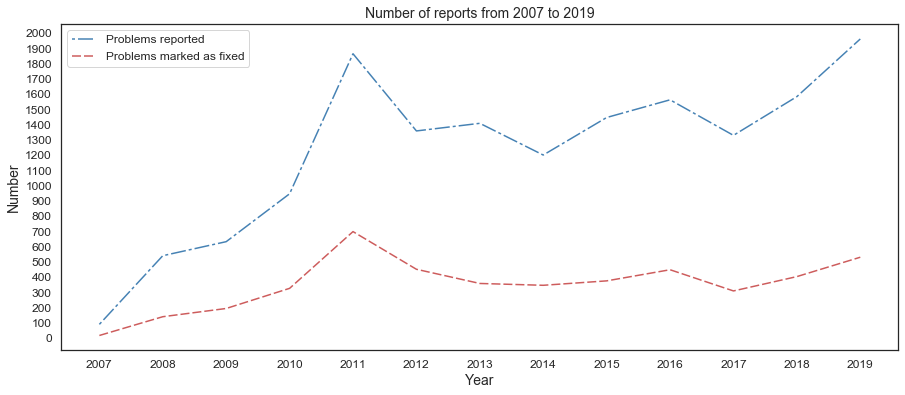

In [567]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(15, 6))
# Using set_dashes() to modify dashing of an existing line
Tcount = data[['report','year']].groupby(['year']).agg(['count']).reset_index()
line1, = ax.plot(Tcount.iloc[:,0:1],Tcount.iloc[:,1:2], label='Problems reported',color='steelblue')
line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

# Using plot(..., dashes=...) to set the dashing when creating a line
Fcount = data[['report','year','fix']].groupby(['year','fix']).agg(['count']).reset_index()
Fcount.drop(Fcount[Fcount['fix']==0].index, axis=0, inplace=True) #drop the rows if fix=0(not fixed yet)
line2, = ax.plot(Fcount.iloc[:,0:1], Fcount.iloc[:,2:3], dashes=[6, 2], label='Problems marked as fixed',color='indianred')

plt.xticks(np.arange(2007, 2020, 1),fontsize=12)
plt.yticks(np.arange(0, 2001, 100),fontsize=12)
plt.xlabel('Year',fontsize=14)
plt.ylabel('Number',fontsize=14)
plt.title('Number of reports from 2007 to 2019', fontsize = 14)
ax.legend(fontsize=12)
plt.show()

<center>Figure 1</center>

In Figure 1, the blue dashed line indicates the number of reported problems per year. The red dashed line indicates the number of problems marked as fixed per year. The plot illustrates that from 2007 to 2011, the number of total reports and fixed reports went up quickly. Although there are fluctuations each year, in general, the number is on the rise. 

Text(0.5, 1.0, 'Number of reports by categories')

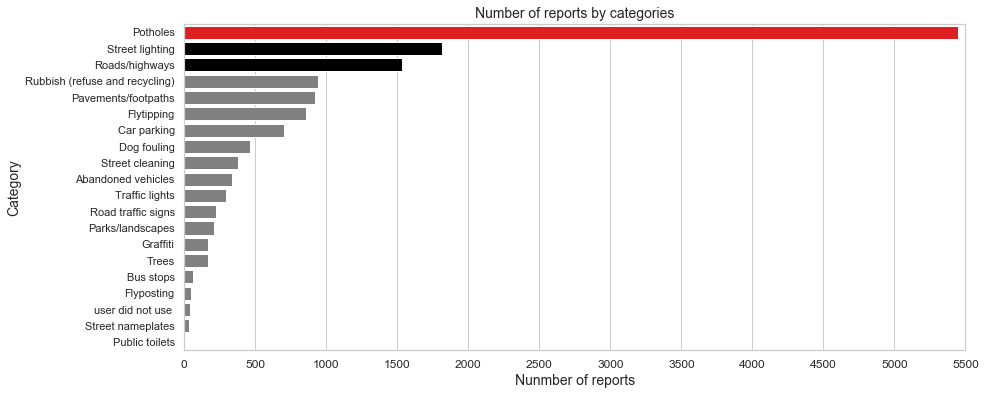

In [533]:
# Count the number of reports for each category and sort the values
Sortedcount = data[['categories','report']].groupby(['categories']).agg({'report': 'count'}).rename(columns={'report':'report_count'}).reset_index().sort_values(by=['report_count'],ascending=False)
Sortedcount.drop(Sortedcount[Sortedcount['categories']=='None'].index, axis=0, inplace=True) #drop the category 'None'

# Set the plot style
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 6))

# Plot the total crashes
sns.set_color_codes("pastel")
values = np.array(Sortedcount['report_count']) 
clrs = ['grey' if (x < values[2]) else 'black' if (x < max(values)) else 'red' for x in values ]
sns.barplot(x="report_count", y="categories", data=Sortedcount,
            palette=clrs)

# Add informative axis label and title
ax.set(xlim=(0, 5500))
plt.xlabel("Nunmber of reports",fontsize=14)
plt.ylabel("Category",fontsize=14)
plt.xticks(np.arange(0, 5501, 500),fontsize=12)
plt.title('Number of reports by categories', fontsize = 14)

<center>Figure 2</center>

The Figure 2 plots the number of reports by categories. The top 3 most reported problems are potholes, street lighting and roads/highways. The number of potholes reports far exceeds the other two categories, approaching 5,500. It's more than twice as often as the second place. The following categories are all reported no more than 1,000.

## 2. Data Visualization

Furthermore, I analyze and visualize the cleaned data regarding the report characteristics and the council response speed.

### 2.1. Report Characteristics Analysis

On the aspect of report characteristics, I plot the number of reports per one-minute time slot and its CDF for analysis.

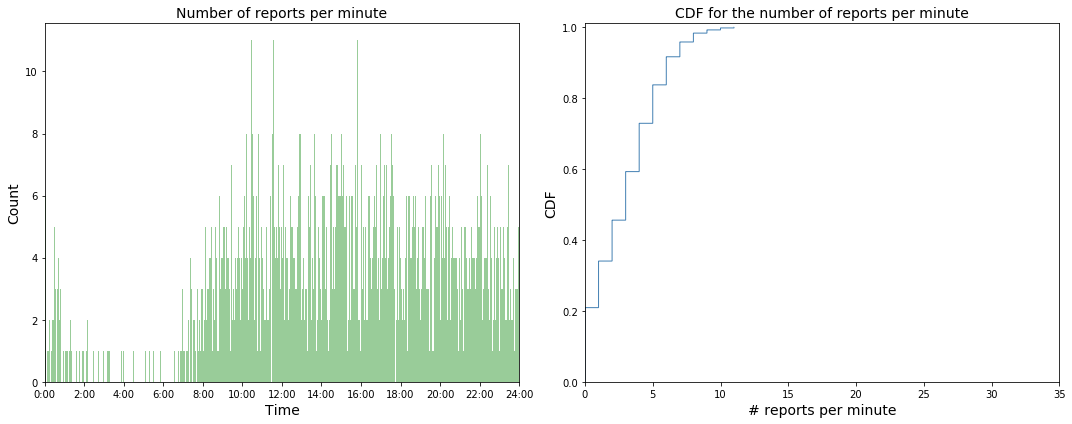

In [55]:
# Number of reprts per one-minute time slot
per_min_ts = data['report_time'].apply(lambda x: 60*x.hour + x.minute) # convert into minutes

# Set up the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15,6)

per_min_n_event, _bins, _patches = ax1.hist(per_min_ts, range(24*60+1), facecolor='green', edgecolor="none", alpha=0.4)

ax1.set_xticks(60*np.arange(0, 26, 2))
ax1.set_xticklabels(('0:00',  '2:00', '4:00', '6:00', '8:00', '10:00', '12:00', '14:00', '16:00', '18:00', '20:00',  '22:00','24:00'))
ax1.set_xlim([0, 24*60])
ax1.set_xlabel('Time',fontsize=14)
ax1.set_ylabel('Count',fontsize=14)
ax1.set_title('Number of reports per minute', fontsize = 14)

# Produce the empirical cumulative distribution for the number of reprts per minute
n_bins = 50000

#fig, ax = plt.subplots(figsize=(4, 4))
_n, _bins, patches = ax2.hist(per_min_n_event, n_bins, density=1, histtype='step', cumulative=1,color='steelblue')

ax2.set_xlabel('# reports per minute',fontsize=14)
ax2.set_ylabel('CDF',fontsize=14)
ax2.set_xlim([0,35])
ax2.set_ylim([0,1.01])
ax2.set_title('CDF for the number of reports per minute', fontsize = 14)
patches[0].set_xy(patches[0].get_xy()[:-1]) # a hack to remove the last point y = 0

plt.tight_layout()
plt.show()

<center>Figure 3,4</center>

The upleft figure depicts the number of reports per one-minute time slot. It demonstrates that the problems are usually reported during the daytime. Besides, there are more reports in commute time, which is intuitive because more people are on the streets at that time. The upright figure is the CDF for the number of reports per minute. The cummulative probability that the number of reports per minute is no more than 8 is about 0.8.

### 2.2. Council Response Speed Analysis

For the analysis of the council response speed, I consider the distribution of response days, which is defined as the time gap measured in days between reported time and fixed time for the fixed problems.

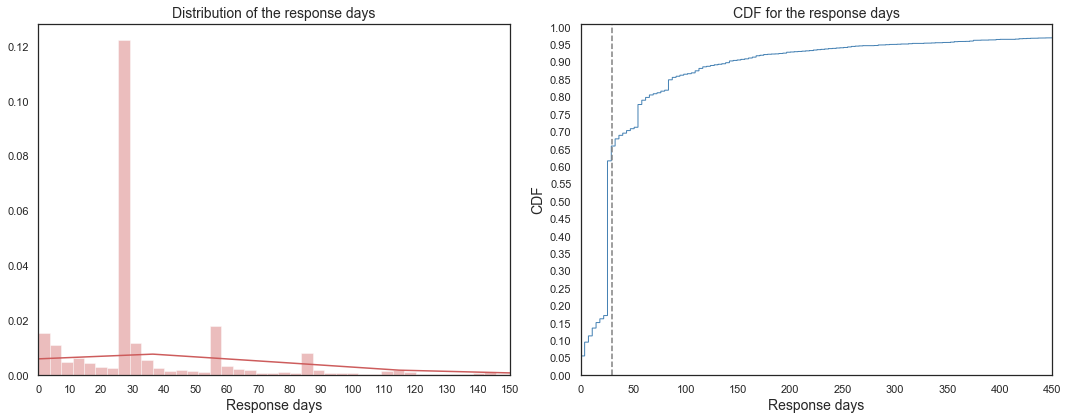

In [699]:
# Set up the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15,6)

# Draw the distribution of the response days
d = data
d.drop(d[d['response_time']=='None'].index, axis=0, inplace=True) ##drop the non-recorded rows

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(d['response_time'], bins=1000,color="indianred",ax=ax1)

# Add informative axis label and title
ax1.set_xlim([0, 150])
ax1.set_xlabel("Response days",fontsize=14)
ax1.set_xticks(np.arange(0, 160, 10))
ax1.set_title('Distribution of the response days', fontsize = 14)

# Produce the empirical cumulative distribution for the response days
n_bins = 1000

_n, _bins, patches = ax2.hist(d['response_time'], n_bins, density=1, histtype='step', cumulative=1,color='steelblue')

ax2.set_xlabel('Response days',fontsize=14)
ax2.set_ylabel('CDF',fontsize=14)
ax2.set_xlim([0,450])
ax2.set_ylim([0,1.01])
ax2.set_title('CDF for the response days', fontsize = 14)
patches[0].set_xy(patches[0].get_xy()[:-1]) # a hack to remove the last point y = 0
plt.xticks(np.arange(0,500, 50))
plt.yticks(np.arange(0,1.05, 0.05))
plt.axvline(30, color = 'grey', linestyle='dashed')

plt.tight_layout()

<center>Figure 5,6</center>

The upleft figure is the histogram and kernel density estimate for the response days. The upper tail is long, which implies that there exist some problems responded slowly. The upright figure is the CDF for the response days. The grey dashed line represents 30 days. It shows that the cummulative probability that the number of response days is no more than 30 is around 0.65, meaning that most of the problems are solved by the local council within a month. This figure also illustrates that the CDF converges to 1 slowly, which is in accordance with the Figure 5.

## Conclusion

We get the conclusion that the number of reports was on the rise from 2007 to 2019 and the potholes problem was most frequently reported, more than twice as often as the second. 

What's more, problems are more likely to be reported during daytime, especially during commute time. And usually, the number of reports per minute is less than eight.

Furthermore, it usually takes the local council less than 30 days to solve the problems. However, the upper tail of the distribution is long, which means some problems wait for a long time to be solved.